OLG Model

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **model analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `modelproject.py` file includes a function which could be used multiple times in this notebook.

Imports and set magics:

In [44]:
import numpy as np
from scipy import optimize
import sympy as sm

# plotting
import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})


# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
from modelproject import OLGModelClass

#Call class containing full model
model = OLGModelClass()
par = model.par # SimpeNamespace
sim = model.sim # SimpeNamespace

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
initializing the model:
calling .setup()
calling .allocate()


# Model description

**Time:** Discrete and indexed by $t\in\{0,1,\dots\}$.

**Demographics:** Population is constant. A life consists of
two periods, *young* and *old*.

**Households:** As young a household supplies labor exogenously, $N_{t}=1$, and earns a after tax wage $(1-\tau_w)w_{t}N_{t}$.<br>
Consumption as young and old are denoted by $C_{1t}$ and $C_{2t+1}$. The after-tax return on saving is $(1-\tau_{r})r_{t+1}$.<br>
Utility is
    
$$
\begin{aligned}
U & =\max_{s_{t}\in[0,1]}\frac{C_{1t}^{1-\sigma}}{1-\sigma}+\beta\frac{C_{2t+1}^{1-\sigma}}{1-\sigma},\,\,\,\beta > -1, \sigma > 0\\
 & \text{s.t.}\\
 & S_{t}=s_{t}(1-\tau_{w})w_{t}N_{t}\\
 & C_{1t}=(1-s_{t})(1-\tau_{w})w_{t}N_{t} + r_t \rho  (1-\tau_{\rho})\\
 & C_{2t+1}=(1+(1-\tau_{r})r_{t+1})S_{t}- \rho
\end{aligned}
$$
    
The problem is formulated in terms of the saving rate $s_t\in[0,1]$.

**Firms:** Firms rent capital $K_{t-1}$ at the rental rate $r_{t}^{K}$,
and hires labor $L_{t}$ at the wage rate $w_{t}$. Firms have access
to the production function
    
$$
\begin{aligned}
Y_{t}=F(K_{t-1},L_{t})=\alpha K_{t-1}^{-\theta}+(1-\alpha)L_{t}^{-\theta},\,\,\,\theta>-1,\alpha\in(0,1)
\end{aligned}
$$
    
Profits are
    
$$
\begin{aligned}
\Pi_{t}=Y_{t}-w_{t}L_{t}-r_{t}^{K}K_{t-1}
\end{aligned}
$$

**Government:** Choose public consumption, $G_{t}$, and tax rates $\tau_w \in [0,1]$, $\tau_r \in [0,1]$ and $\tau_{\rho} \in [0,1]$. Total tax revenue is
    
$$
\begin{aligned}
T_{t} &=\tau_r r_{t} (K_{t-1}+B_{t-1})+\tau_w w_{t}N_{t} + \rho \tau_{\rho}r_{t}
\end{aligned}
$$
    
Government debt accumulates according to
    
$$
\begin{aligned}
B_{t} &=(1+r^b_{t})B_{t-1}-T_{t}+G_{t} 
\end{aligned}
$$
       
A *balanced budget* implies $G_{t}=T_{t}-r_{t}B_{t-1}$.

**Capital:** Depreciates with a rate of $\delta \in [0,1]$.

**Equilibrium:**

1. Households maximize utility
2. Firms maximize profits
3. No-arbitrage between bonds and capital

    $$
    r_{t}=r_{t}^{K}-\delta=r_{t}^{b}
    $$

4. Labor market clears: $L_{t}=N_{t}=1$
5. Goods market clears: $Y_{t}=C_{1t}+C_{2t}+G_{t}+I_{t}$
6. Asset market clears: $S_{t}=K_{t}+B_{t}$
7. Capital follows its law of motion: $K_{t}=(1-\delta)K_{t-1}+I_{t}$

### 1.1. <a id='toc1_1_'></a>[Solution and simulation](#toc0_)

**Implication of profit maximization:** From FOCs

$$
\begin{aligned}
r_{t}^{k} & =F_{K}(K_{t-1},L_{t})=\alpha K_{t-1}^{-\theta-1}Y_{t}^{1+\theta}\\
w_{t} & =F_{L}(K_{t-1},L_{t})=(1-\alpha)L_{t}^{-\theta-1}Y_{t}^{1+\theta}
\end{aligned}
$$

**Implication of utility maximization:** From FOC

$$
\begin{aligned}
C_{1t}^{-\sigma}=\beta (1+(1-\tau_r)r_{t+1})C_{2t+1}^{-\sigma}
\end{aligned}
$$

**Simulation algorithm:** At the beginning of period $t$, the
economy can be summarized in the state variables $K_{t-1}$ and $B_{t-1}$.<br>
*Before* $s_t$ is known, we can calculate:

$$
\begin{aligned}
Y_{t} & =F(K_{t-1},1)\\
r_{t}^{k} & =F_{K}(K_{t-1},1)\\
w_{t} & =F_{L}(K_{t-1},1)\\
r_{t} & =r^k_{t}-\delta\\
r_{t}^{b} & =r_{t}\\
\tilde{r}_{t} & =(1-\tau_{r})r_{t}\\
C_{2t} & =(1+\tilde{r}_{t})(K_{t-1}+B_{t-1})\\
T_{t} & =\tau_{r}r_{t}(K_{t-1}+B_{t-1})+\tau_{w}w_{t}\\
B_{t} & =(1+r^b_{t})B_{t-1}+T_{t}-G_{t}\\
\end{aligned}
$$

*After* $s_t$ is known we can calculate:

$$
\begin{aligned}
C_{1t} & = (1-s_{t})(1-\tau_{w})w_{t}\\
I_{t} & =Y_{t}-C_{1t}-C_{2t}-G_{t}\\
K_{t} & =(1-\delta)K_{t-1} + I_t
\end{aligned}
$$

**Solution algorithm:** Simulate forward choosing $s_{t}$ so
that we always have

$$
\begin{aligned}
C_{1t}^{-\sigma}=\beta(1+\tilde{r}_{t+1})C_{2t+1}^{-\sigma}
\end{aligned}
$$

**Implementation:**

1. Use a bisection root-finder to determine $s_t$
2. Low $s_t$: A lot of consumption today. Low marginal utility. LHS < RHS.
3. High $s_t$: Little consumption today. High marginal utility. LHS > RHS.
4. Problem: Too low $s_t$ might not be feasible if $B_t > 0$.

**Note:** Never errors in the Euler-equation due to *perfect foresight*.

## Simple model to test the algorithm

First off we wish to test the simulation process using a simpler version of the model. This first and easier model will be based off of a Cobb-Douglas model in which utility is logarithmic and the government doesn't do anything. This will later be changed.  The formula for steady state in this is  given as: $$ \lim_{t\rightarrow\infty} K_t = \left(\frac{1-\alpha}{1+1/\beta}\right)^{\frac{1}{1-\alpha}} $$ The analytical solution has been incorporated into the OLSModelClass to allow easier comparison if it is decided to change parameters in the model. 

simulation done in 0.01 secs
t =  0: euler-error = -0.00000000
t =  1: euler-error = -0.00000000
t =  2: euler-error = -0.00000000
t =  3: euler-error = -0.00000000
t =  4: euler-error = -0.00000000


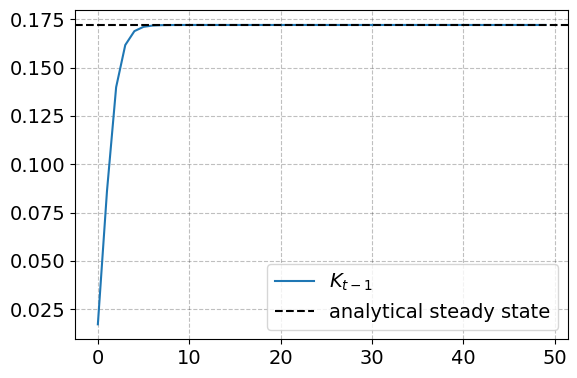

In [53]:
# a. production
par.production_function = 'cobb-douglas'
par.theta = 0.0
# b. households
par.sigma = 1.0
# c. government
par.tau_w = 0.0
par.tau_r = 0.0
# sim.balanced_budget[:] = True # G changes to achieve this


model.anaSSk() #Calculate the analytical steady state and store the value in K_ss. This will also activate the initial value for the lag in k
model.simulate()
for t in range(5):
    LHS_Euler = sim.C1[t]**(-par.sigma)
    RHS_Euler = (1+sim.rt[t+1])*par.beta * sim.C2[t+1]**(-par.sigma)
    print(f't = {t:2d}: euler-error = {LHS_Euler-RHS_Euler:.8f}')
fig = plt.figure(figsize=(6,6/1.5))
ax = fig.add_subplot(1,1,1)
ax.plot(model.sim.K_lag,label=r'$K_{t-1}$')
ax.axhline(model.anaSSk(),ls='--',color='black',label='analytical steady state')
ax.legend(frameon=True)
fig.tight_layout()
K_lag_old = model.sim.K_lag.copy()

# Our extension to the model

Now for the more interesting part. We have decided to extend the model in the following ways:

1. Inheritance $\rho$ which will be taxed $\tau_{\rho}$ and have same return as capital
2. Active government, ie. non zero $\tau$ - We introduce taxes on capital, wages and inheritance

In [54]:
model.setup

<bound method OLGModelClass.setup of <modelproject.OLGModelClass object at 0x000002668566CB80>>

# Conclusion

Add concise conclusion. 